#Proyecto Minería de Datos
- Valeria Herrera Villamizar
- George Plata Bello
- Diego Sandoval Skinner 

# **Modelo Atencional**

Una modelo atencional se describe como la asignación de una consulta y un conjunto de pares clave-valor a una salida,
donde la consulta, las claves, los valores y la salida son todos vectores. La salida se calcula como una suma ponderada
de los valores, donde el peso asignado a cada valor se calcula mediante una función de compatibilidad de la
consulta con la clave correspondiente.

# **Modelo Transformer Redes Recurrentes RNNs**

Como se vio anteriormente, el modelo atencional une la computación paralela y el camino mas corto de longitud. El objetivo de este proyecto será implementar un diseño de arquitectura profundo usando únicamente modelos atencionales, particularmente modelos "self-attention".





Es importante recalcar que el modelo Transformer se basa exclusivamente de los modelos atencionales [(Aston Zhang pag. 441)]. Este tipo de modelos han sido utilizados en un amplio campo de aplicaciones del aprendizaje profundo como en áreas de **lenguaje**, visión, discurso y aprendizaje reforzado.

En este caso, esta metodología será implementada con el objetivo de crear un algorítmo que permita hacer la **traducción** de un conjunto de datos de texto de un lenguaje a otro. 

## **El** **Modelo** 

La arquitectura general del modelo Transformer la podemos apreciar en la siguiente imagen tomada del libro Aston Zhang, Zachary C. Lipton (2021)

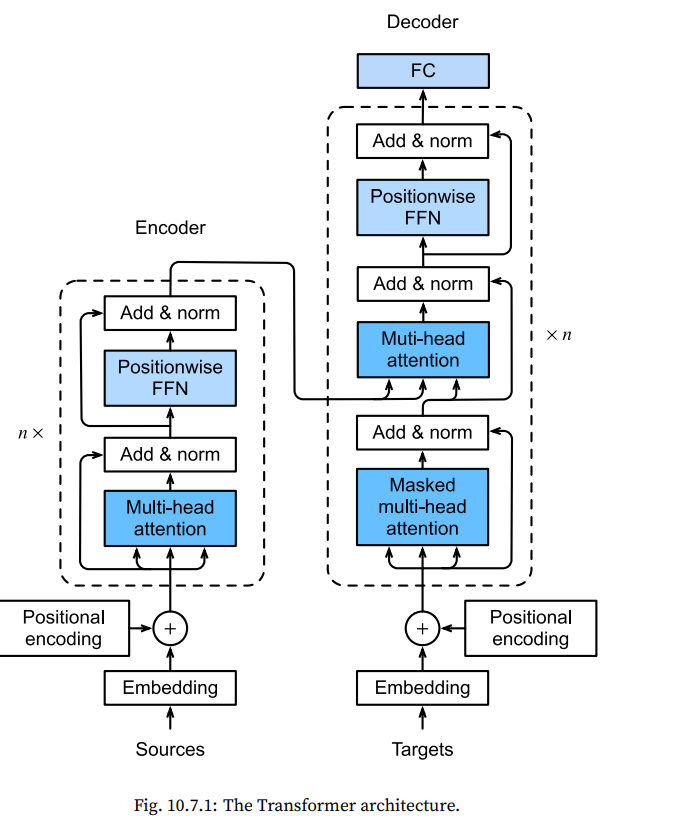

Como se puede apreciar la estrucutra de este modelo se compone de una estructura de **codificado** y **decodificado**


Estas dos clases (decode y encode), se derivan en multiples capas donde cada capa a su vez se divide en dos subcapas, cada una compuesta de dos partes: un agrupamiento multiple de auto-atención *"multi-head self-attention"*y una red de alimentación por posición o *"positionwise feed-forward network"*. 

Estas 

# **Datasets**



In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [ ]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs
 
# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
# load dataset
filename = '/content/drive/My Drive/Minería de datos/Datos_GermanEnglish/DeutschEnglish.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'DeutschEnglish.pkl')
# spot check
for i in range(100):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

In [ ]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle
 
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
# load dataset
raw_dataset = load_clean_sentences('DeutschEnglish.pkl')
 
# reduce dataset size
n_sentences = 20000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:18000], dataset[18000:]
# save
save_clean_data(dataset, 'DeutschEnglish-both.pkl')
save_clean_data(train, 'DeutschEnglish-train.pkl')
save_clean_data(test, 'DeutschEnglish-test.pkl')

Saved: DeutschEnglish-both.pkl
Saved: DeutschEnglish-train.pkl
Saved: DeutschEnglish-test.pkl


# First Model

In [ ]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

Se cargan los archivos con el dataset filtrado, los datos de entrenamiento y los datos de prueba.

In [ ]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# load datasets
dataset = load_clean_sentences('DeutschEnglish-both.pkl')
train = load_clean_sentences('DeutschEnglish-train.pkl')
test = load_clean_sentences('DeutschEnglish-test.pkl')

Se utiliza la clase Keras Tokenize para mapear las palabras a números enteros según sea necesario para el modelado. Se usa un tokenizador separado para las secuencias en inglés y las secuencias en alemán. La función a continuación llamada create_tokenizer () entrenará un tokenizador en una lista de frases.

In [ ]:
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

La función denominada max_length () a continuación encontrará la longitud de la secuencia más larga en una lista de frases.

In [ ]:
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

Podemos llamar a estas funciones con el conjunto de datos combinado para preparar tokenizadores, tamaños de vocabulario y longitudes máximas para las frases en inglés y alemán.

In [ ]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

English Vocabulary Size: 3816
English Max Length: 6
German Vocabulary Size: 6192
German Max Length: 10


Cada secuencia de entrada y salida debe codificarse en números enteros y *padded* con la longitud máxima de frase. Esto se debe a que usaremos *a word embedding* para las secuencias de entrada y  *one hot encode* para las secuencias de salida.

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

La secuencia de salida debe estar  one hot encode. Esto se debe a que el modelo predecirá la probabilidad de cada palabra del vocabulario como salida.

In [ ]:
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

Podemos hacer uso de estas dos funciones y preparar tanto el tren como el conjunto de datos de prueba listos para entrenar el modelo.

In [ ]:
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

## Model

Se usa un modelo LSTM codificador-decodificador (encoder-decoder LSTM model) en este problema. En esta arquitectura, la secuencia de entrada es codificada por un modelo de front-end llamado codificador y luego decodificado palabra por palabra por un modelo de backend llamado decodificador.

La función define_model () a continuación define el modelo y toma una serie de argumentos utilizados para configurar el modelo, como el tamaño de los vocabularios de entrada y salida, la longitud máxima de las frases de entrada y salida y la cantidad de unidades de memoria utilizadas para configurar el modelo.

El modelo se entrena utilizando el enfoque de "Adam" para el descenso de gradiente estocástico y minimiza la función de pérdida categórica porque hemos enmarcado el problema de predicción como una clasificación de clases múltiples.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 256)           1585152   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 6, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 256)            525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 6, 3816)           980712    
Total params: 3,616,488
Trainable params: 3,616,488
Non-trainable params: 0
_________________________________________________________________
None


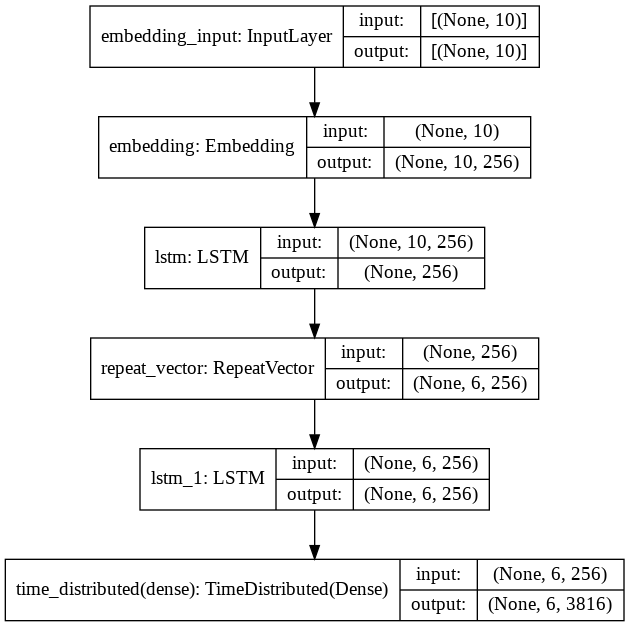

In [ ]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

Entrenamos el modelo con 30 epochs y un batch size de 64 ejemplos.

Usamos puntos de control para asegurarnos de que cada vez que mejora la habilidad del modelo en el conjunto de prueba, el modelo se guarda en un archivo.

In [ ]:
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Epoch 1/30
282/282 - 64s - loss: 4.0136 - val_loss: 3.4782

Epoch 00001: val_loss improved from inf to 3.47822, saving model to model.h5
Epoch 2/30
282/282 - 56s - loss: 3.3698 - val_loss: 3.3640

Epoch 00002: val_loss improved from 3.47822 to 3.36396, saving model to model.h5
Epoch 3/30
282/282 - 53s - loss: 3.2169 - val_loss: 3.2379

Epoch 00003: val_loss improved from 3.36396 to 3.23789, saving model to model.h5
Epoch 4/30
282/282 - 53s - loss: 3.0314 - val_loss: 3.0647

Epoch 00004: val_loss improved from 3.23789 to 3.06473, saving model to model.h5
Epoch 5/30
282/282 - 53s - loss: 2.7948 - val_loss: 2.8505

Epoch 00005: val_loss improved from 3.06473 to 2.85047, saving model to model.h5
Epoch 6/30
282/282 - 53s - loss: 2.5413 - val_loss: 2.6470

Epoch 00006: val_loss improved from 2.85047 to 2.64699, saving model to model.h5
Epoch 7/30
282/282 - 53s - loss: 2.3043 - val_loss: 2.4956

Epoch 00007: val_loss improved from 2.64699 to 2.49562, saving model to model.h5
Epoch 8/30
282/28

## Evaluate

Evaluaremos el modelo en el conjunto de datos de entrenamiento y el conjunto de datos de prueba.

El modelo debería funcionar muy bien en el conjunto de datos de entrenamiento y, idealmente, se ha generalizado para funcionar bien en el conjunto de datos de prueba.

Los conjuntos de datos limpios deben cargarse y prepararse como antes.

In [19]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

In [17]:
# load datasets
dataset = load_clean_sentences('DeutschEnglish-both.pkl')
train = load_clean_sentences('DeutschEnglish-train.pkl')
test = load_clean_sentences('DeutschEnglish-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

In [20]:
# load model
model = load_model('model.h5')

La evaluación implica dos pasos: primero generar una secuencia de salida traducida y luego repetir este proceso para muchos ejemplos de entrada y resumir la habilidad del modelo en varios casos.

In [22]:
#translation = model.predict(source, verbose=0)

Esta será una secuencia de números enteros que podemos enumerar y buscar en el tokenizador para mapear las palabras.

La función siguiente, denominada word_for_id (), realizará este mapeo inverso.

In [23]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

Podemos realizar este mapeo para cada número entero en la traducción y devolver el resultado como una cadena de palabras.

La función predict_sequence () a continuación realiza esta operación para una sola frase fuente codificada.

In [24]:
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

A continuación, podemos repetir esto para cada frase de origen en un conjunto de datos y comparar el resultado predicho con la frase de destino esperada en inglés.

Podemos imprimir algunas de estas comparaciones en la pantalla para tener una idea de cómo funciona el modelo en la práctica.

También calcularemos los puntajes BLEU para tener una idea cuantitativa de qué tan bien se ha desempeñado el modelo.

In [26]:
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [27]:
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[das ist wichtig], target=[its important], predicted=[its matters]
src=[schauen sie genau zu], target=[watch closely], predicted=[watch closely]
src=[du siehst krank aus], target=[you look sick], predicted=[you look sick]
src=[tom hat es gewusst], target=[tom knew], predicted=[tom knew]
src=[die schule macht keinen spa], target=[schools not fun], predicted=[its not fun]
src=[dies ist ein bleistift], target=[this is a pencil], predicted=[this is a pencil]
src=[sags tom doch selbst], target=[tell tom yourself], predicted=[tell tom yourself]
src=[sie ist auf diat], target=[shes dieting], predicted=[shes is dieting]
src=[sie hat ihn weinen gehort], target=[she heard him cry], predicted=[she heard him cry]
src=[hat tom sich geschlagen gegeben], target=[did tom surrender], predicted=[did tom surrender you]
BLEU-1: 0.867050
BLEU-2: 0.807048
BLEU-3: 0.757159
BLEU-4: 0.593031
test
src=[bist du optimistisch], target=[are you optimistic], predicted=[are you independent]
src=[ich schlief